ModuleNotFoundError: ignored

In [0]:
# Ricardo Carrillo REINFORCE MOUNTAIN_CAR
%tensorflow_version 1.x
import numpy as np
import sklearn
import sklearn.preprocessing
import tensorflow as tf
from tensorflow.contrib import rnn


class MLPStochasticPolicyAgent:
    def __init__(self, env, num_input, init_learning_rate=5e-6, min_learning_rate=1e-9, learning_rate_N_max=2000,
                 shuffle=True, batch_size=1, sigma=None):
        self._env = env
        self._sess = tf.Session()
        self._states = tf.placeholder(tf.float32, (None, num_input), name="states")

        self._init_learning_rate = init_learning_rate
        self._min_learning_rate = min_learning_rate
        self._learning_rate_N_max = learning_rate_N_max
        self._learning_rate = tf.placeholder(tf.float32, shape=[])

        self._phi_hidden = 128
        self._sigma_hidden = 32

        # policy parameters
        self._mu_theta = tf.get_variable("mu_theta", [self._phi_hidden, 1],
                                         initializer=tf.zeros_initializer())
        if sigma is None:
            self._sigma_theta = tf.get_variable("sigma_theta", [self._sigma_hidden],
                                                initializer=tf.zeros_initializer())

        # neural featurizer parameters
        self._W1 = tf.get_variable("W1", [num_input, self._phi_hidden],
                                   initializer=tf.random_normal_initializer())
        self._b1 = tf.get_variable("b1", [self._phi_hidden],
                                   initializer=tf.constant_initializer(0))
        self._h1 = tf.nn.tanh(tf.matmul(self._states, self._W1) + self._b1)
        self._W2 = tf.get_variable("W2", [self._phi_hidden, self._phi_hidden],
                                   initializer=tf.random_normal_initializer())
        self._b2 = tf.get_variable("b2", [self._phi_hidden],
                                   initializer=tf.constant_initializer(0))
        self._phi = tf.nn.tanh(tf.matmul(self._h1, self._W2) + self._b2)

        self._mu = tf.matmul(self._phi, self._mu_theta)
        if sigma is None:
            self._sigma = tf.reduce_sum(self._sigma_theta)
            self._sigma = tf.exp(self._sigma)
        else:
            self._sigma = tf.constant(sigma, dtype=tf.float32)

        self._optimizer = tf.train.GradientDescentOptimizer(learning_rate=self._learning_rate)

        self._discounted_rewards = tf.placeholder(tf.float32, (None, 1), name="discounted_rewards")
        self._taken_actions = tf.placeholder(tf.float32, (None, 1), name="taken_actions")

        # we'll get the policy gradient by using -log(pdf), where pdf is the PDF of the Normal distribution
        self._loss = -tf.log(tf.sqrt(1/(2 * np.pi * self._sigma**2)) * tf.exp(-(self._taken_actions - self._mu)**2/(2 * self._sigma**2))) * self._discounted_rewards

        self._train_op = self._optimizer.minimize(self._loss)

        self._sess.run(tf.global_variables_initializer())

        self._num_input = num_input
        self._shuffle = shuffle
        self._batch_size = batch_size
        # rollout buffer
        self._state_buffer  = []
        self._reward_buffer = []
        self._action_buffer = []
        # record reward history for normalization
        self._all_rewards = []
        self._max_reward_length = 1000000
        self._discount_factor = 0.99

        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        self._scaler = sklearn.preprocessing.StandardScaler()
        self._scaler.fit(observation_examples)

    def sample_action(self, system_state):
        system_state = self._scaler.transform(system_state.reshape(1, -1))
        # Gaussian policy
        mu, sigma = self._sess.run([self._mu, self._sigma], feed_dict={
            self._states: system_state
        })
        action = np.random.normal(mu, sigma)
        action = np.clip(action, self._env.action_space.low[0], self._env.action_space.high[0])
        return action[0], sigma

    def store_rollout(self, state, action, reward):
        self._action_buffer.append(action)
        self._reward_buffer.append(reward)
        self._state_buffer.append(state)

    def update_model(self, iteration):
        N = len(self._reward_buffer)
        r = 0  # use discounted reward to approximate Q value

        discounted_rewards = np.zeros(N)
        for t in reversed(range(N)):
            r = self._reward_buffer[t] + self._discount_factor * r
            discounted_rewards[t] = r

        # reduce gradient variance by normalization
        self._all_rewards += discounted_rewards.tolist()
        self._all_rewards = self._all_rewards[:self._max_reward_length]
        discounted_rewards -= np.mean(self._all_rewards)
        discounted_rewards /= np.std(self._all_rewards)

        learning_rate = self._gen_learning_rate(iteration, l_max=self._init_learning_rate,
                                                l_min=self._min_learning_rate, N_max=self._learning_rate_N_max)

        all_samples = []
        for t in range(N-1):
            state  = self._state_buffer[t]
            action = self._action_buffer[t]
            reward = [discounted_rewards[t]]
            sample = [state, action, reward]
            all_samples.append(sample)
        if self._shuffle:
            np.random.shuffle(all_samples)

        batches = list(self._minibatches(all_samples, batch_size=self._batch_size))

        for b in range(len(batches)):
            batch = batches[b]
            states = [row[0] for row in batch]
            actions = [row[1] for row in batch]
            rewards = [row[2] for row in batch]

            self._sess.run([self._train_op], {
                self._states:             states,
                self._taken_actions:      actions,
                self._discounted_rewards: rewards,
                self._learning_rate:      learning_rate
            })

        self._clean_up()

    def _minibatches(self, samples, batch_size):
        for i in range(0, len(samples), batch_size):
            yield samples[i:i + batch_size]

    def _gen_learning_rate(self, iteration, l_max, l_min, N_max):
        if iteration > N_max:
            return l_min
        alpha = 2 * l_max
        beta = np.log((alpha / l_min - 1)) / N_max
        return alpha / (1 + np.exp(beta * iteration))

    def _clean_up(self):
        self._state_buffer  = []
        self._reward_buffer = []
        self._action_buffer = []


class TFRecurrentStochasticPolicyAgent:
    def __init__(self, env, num_input, init_learning_rate=5e-6, min_learning_rate=1e-9, learning_rate_N_max=2000,
                 shuffle=True, batch_size=1, sigma=None):
        self._env = env
        self._sess = tf.Session()

        self._init_learning_rate = init_learning_rate
        self._min_learning_rate = min_learning_rate
        self._learning_rate_N_max = learning_rate_N_max
        self._learning_rate = tf.placeholder(tf.float32, shape=[])

        self._rnn_hidden = 10
        self._rnn_steps = 5
        self._sigma_hidden = 32

        self._states = tf.placeholder(tf.float32, (None, self._rnn_steps, num_input), name="states")

        # policy parameters
        self._mu_theta = tf.get_variable("mu_theta", [self._rnn_hidden, 1],
                                         initializer=tf.zeros_initializer())
        if sigma is None:
            self._sigma_theta = tf.get_variable("sigma_theta", [self._sigma_hidden],
                                                initializer=tf.zeros_initializer())

        # neural featurizer parameters
        # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
        input_sequence = tf.unstack(self._states, self._rnn_steps, 1)
        lstm_cell = rnn.LSTMCell(self._rnn_hidden, forget_bias=1.0, initializer=tf.random_normal_initializer())
        outputs, _ = rnn.static_rnn(lstm_cell, input_sequence, dtype=tf.float32)
        self._phi = outputs[-1]

        self._mu = tf.matmul(self._phi, self._mu_theta)
        if sigma is None:
            self._sigma = tf.reduce_sum(self._sigma_theta)
            self._sigma = tf.exp(self._sigma)
        else:
            self._sigma = tf.constant(sigma, dtype=tf.float32)

        self._optimizer = tf.train.GradientDescentOptimizer(learning_rate=self._learning_rate)

        self._discounted_rewards = tf.placeholder(tf.float32, (None, 1), name="discounted_rewards")
        self._taken_actions = tf.placeholder(tf.float32, (None, 1), name="taken_actions")

        # we'll get the policy gradient by using -log(pdf), where pdf is the PDF of the Normal distribution
        self._loss = -tf.log(tf.sqrt(1/(2 * np.pi * self._sigma**2)) * tf.exp(-(self._taken_actions - self._mu)**2/(2 * self._sigma**2))) * self._discounted_rewards

        self._train_op = self._optimizer.minimize(self._loss)

        self._sess.run(tf.global_variables_initializer())

        self._num_input = num_input
        self._shuffle = shuffle
        self._batch_size = batch_size
        # rollout buffer
        self._state_buffer  = []
        self._reward_buffer = []
        self._action_buffer = []
        # record reward history for normalization
        self._all_rewards = []
        self._max_reward_length = 1000000
        self._discount_factor = 0.99

        self._start_state_value = 0.

    def sample_action(self, env_state):
        states = self._prepare_states(env_state)
        # Gaussian policy
        mu, sigma = self._sess.run([self._mu, self._sigma], feed_dict={
            self._states: np.reshape(states, (1, self._rnn_steps, self._num_input))
        })
        action = np.random.normal(mu, sigma)
        action = np.clip(action, self._env.action_space.low[0], self._env.action_space.high[0])
        return action[0], sigma

    def _prepare_states(self, env_state):
        curr_state = self._filter_state(env_state)
        stack_len = self._rnn_steps - 1
        states = [[x[0]] for x in self._state_buffer]
        if len(states) is 0:
            self._start_state_value = env_state[0]
        while len(states) < stack_len:
            states.insert(0, [self._start_state_value])
        return states[-stack_len:] + [curr_state]

    def _filter_state(self, env_state):
        return [env_state[0]]

    def store_rollout(self, env_state, action, reward):
        self._action_buffer.append(action)
        self._reward_buffer.append(reward)
        self._state_buffer.append(self._filter_state(env_state))

    def update_model(self, iteration):
        N = len(self._reward_buffer)
        r = 0  # use discounted reward to approximate Q value

        discounted_rewards = np.zeros(N)
        for t in reversed(range(N)):
            r = self._reward_buffer[t] + self._discount_factor * r
            discounted_rewards[t] = r

        # reduce gradient variance by normalization
        self._all_rewards += discounted_rewards.tolist()
        self._all_rewards = self._all_rewards[:self._max_reward_length]
        discounted_rewards -= np.mean(self._all_rewards)
        discounted_rewards /= np.std(self._all_rewards)

        learning_rate = self._gen_learning_rate(iteration, l_max=self._init_learning_rate,
                                                l_min=self._min_learning_rate, N_max=self._learning_rate_N_max)

        all_samples = []
        for t in range(N-1):
            last = t + 1
            first = max(0, last - self._rnn_steps)
            states = self._state_buffer[first:last]
            while len(states) < self._rnn_steps:
                states.insert(0, [self._start_state_value])
            states = np.reshape(np.array(states), (self._rnn_steps, self._num_input))
            action = self._action_buffer[t]
            reward = [discounted_rewards[t]]
            sample = [states, action, reward]
            all_samples.append(sample)
        if self._shuffle:
            np.random.shuffle(all_samples)

        batches = list(self._minibatches(all_samples, batch_size=self._batch_size))

        for b in range(len(batches)):
            batch = batches[b]
            states = [row[0] for row in batch]
            actions = [row[1] for row in batch]
            rewards = [row[2] for row in batch]

            self._sess.run([self._train_op], {
                self._states:             states,
                self._taken_actions:      actions,
                self._discounted_rewards: rewards,
                self._learning_rate:      learning_rate
            })

        self._clean_up()

    def _minibatches(self, samples, batch_size):
        for i in range(0, len(samples), batch_size):
            yield samples[i:i + batch_size]

    def _gen_learning_rate(self, iteration, l_max, l_min, N_max):
        if iteration > N_max:
            return l_min
        alpha = 2 * l_max
        beta = np.log((alpha / l_min - 1)) / N_max
        return alpha / (1 + np.exp(beta * iteration))

    def _clean_up(self):
        self._state_buffer  = []
        self._reward_buffer = []
        self._action_buffer = []


class TFRecurrentStochasticPolicyAgent2:
    def __init__(self, env, num_input, init_learning_rate=5e-6, min_learning_rate=1e-9, learning_rate_N_max=2000,
                 shuffle=True, batch_size=1):
        self._env = env
        self._sess = tf.Session()
        self._states = tf.placeholder(tf.float32, (None, 1, num_input), name="states")

        self._init_learning_rate = init_learning_rate
        self._min_learning_rate = min_learning_rate
        self._learning_rate_N_max = learning_rate_N_max
        self._learning_rate = tf.placeholder(tf.float32, shape=[])

        self._rnn_hidden = 128
        self._sigma_hidden = 32

        # policy parameters
        self._mu_theta = tf.get_variable("mu_theta", [self._rnn_hidden, 1],
                                         initializer=tf.zeros_initializer())
        self._sigma_theta = tf.get_variable("sigma_theta", [self._sigma_hidden],
                                            initializer=tf.zeros_initializer())

        # LSTM featurizer
        input_sequence = tf.unstack(self._states, 1, 1)
        self._lstm_cell = rnn.BasicLSTMCell(self._rnn_hidden, forget_bias=1.0)
        self._rnn_state_in = self._lstm_cell.zero_state(1, tf.float32)
        self._curr_rnn_state = (np.zeros([1, self._rnn_hidden]), np.zeros([1, self._rnn_hidden]))
        outputs, self._rnn_state = rnn.static_rnn(self._lstm_cell, input_sequence, dtype=tf.float32, initial_state=self._rnn_state_in)

        self._phi = outputs[-1]

        self._mu = tf.matmul(self._phi, self._mu_theta)
        self._sigma = tf.reduce_sum(self._sigma_theta)
        self._sigma = tf.exp(self._sigma)

        self._optimizer = tf.train.GradientDescentOptimizer(learning_rate=self._learning_rate)

        self._discounted_rewards = tf.placeholder(tf.float32, (None, 1), name="discounted_rewards")
        self._taken_actions = tf.placeholder(tf.float32, (None, 1), name="taken_actions")

        # we'll get the policy gradient by using -log(pdf), where pdf is the PDF of the Normal distribution
        self._loss = -tf.log(tf.sqrt(1/(2 * np.pi * self._sigma**2)) * tf.exp(-(self._taken_actions - self._mu)**2/(2 * self._sigma**2))) * self._discounted_rewards

        self._train_op = self._optimizer.minimize(self._loss)

        self._sess.run(tf.global_variables_initializer())

        self._num_input = num_input
        self._shuffle = shuffle
        self._batch_size = batch_size
        # rollout buffer
        self._state_buffer  = []
        self._reward_buffer = []
        self._action_buffer = []
        # record reward history for normalization
        self._all_rewards = []
        self._max_reward_length = 1000000
        self._discount_factor = 0.99

    def sample_action(self, system_state):
        state = self._filter_state(system_state)
        # Gaussian policy
        mu, sigma, s = self._sess.run([self._mu, self._sigma, self._rnn_state], feed_dict={
            self._states: np.reshape(state, (1, 1, self._num_input)),
            self._rnn_state_in: self._curr_rnn_state
        })
        self._curr_rnn_state = s
        action = np.random.normal(mu, sigma)
        action = np.clip(action, self._env.action_space.low[0], self._env.action_space.high[0])
        return action[0], sigma

    def _filter_state(self, env_state):
        return [env_state[0]]

    def store_rollout(self, env_state, action, reward):
        self._action_buffer.append(action)
        self._reward_buffer.append(reward)
        self._state_buffer.append(self._filter_state(env_state))

    def update_model(self, iteration):
        N = len(self._reward_buffer)
        r = 0 # use discounted reward to approximate Q value

        # compute discounted future rewards
        discounted_rewards = np.zeros(N)
        for t in reversed(range(N)):
            # future discounted reward from now on
            r = self._reward_buffer[t] + self._discount_factor * r
            discounted_rewards[t] = r

        # reduce gradient variance by normalization
        self._all_rewards += discounted_rewards.tolist()
        self._all_rewards = self._all_rewards[:self._max_reward_length]
        discounted_rewards -= np.mean(self._all_rewards)
        discounted_rewards /= np.std(self._all_rewards)

        learning_rate = self._gen_learning_rate(iteration, l_max=self._init_learning_rate,
                                                l_min=self._min_learning_rate, N_max=self._learning_rate_N_max)

        all_samples = []
        for t in range(N-1):
            state  = [self._state_buffer[t]]
            action = self._action_buffer[t]
            reward = [discounted_rewards[t]]
            sample = [state, action, reward]
            all_samples.append(sample)
        if self._shuffle:
            np.random.shuffle(all_samples)

        batches = list(self._minibatches(all_samples, batch_size=self._batch_size))

        curr_rnn_state = (np.zeros([1, self._rnn_hidden]), np.zeros([1, self._rnn_hidden]))

        for b in range(len(batches)):
            batch = batches[b]
            states = [row[0] for row in batch]
            actions = [row[1] for row in batch]
            rewards = [row[2] for row in batch]
            # perform one update of training
            _, s = self._sess.run([self._train_op, self._rnn_state], {
                self._states:             states,
                self._taken_actions:      actions,
                self._discounted_rewards: rewards,
                self._learning_rate:      learning_rate,
                self._rnn_state_in: curr_rnn_state
            })
            curr_rnn_state = s

        self._clean_up()

    def _minibatches(self, samples, batch_size):
        for i in range(0, len(samples), batch_size):
            yield samples[i:i + batch_size]

    def _gen_learning_rate(self, iteration, l_max, l_min, N_max):
        if iteration > N_max:
            return l_min
        alpha = 2 * l_max
        beta = np.log((alpha / l_min - 1)) / N_max
        return alpha / (1 + np.exp(beta * iteration))

    def _clean_up(self):
        self._state_buffer  = []
        self._reward_buffer = []
        self._action_buffer = []
        self._curr_rnn_state = (np.zeros([1, self._rnn_hidden]), np.zeros([1, self._rnn_hidden]))

TensorFlow 1.x selected.


In [0]:
import gym

#from rl.reinforce.agent import *

# MountainCarContinuous-v0 defines "solving" as getting an average reward of 90.0 over 100 consecutive trials.
env = gym.envs.make("MountainCarContinuous-v0")

state_dim = env.observation_space.shape[0]

MAX_EPISODES = 200
MAX_STEPS = 1000
scores=[]
# agent = MLPStochasticPolicyAgent(env, num_input=state_dim, init_learning_rate=5e-5, min_learning_rate=1e-10,
#                                  learning_rate_N_max=2000, shuffle=True, batch_size=24, sigma=None)

# agent = TFRecurrentStochasticPolicyAgent(env, num_input=1, init_learning_rate=5e-5, min_learning_rate=1e-10,
#                                          learning_rate_N_max=2000, shuffle=True, batch_size=24, sigma=None)

agent = TFRecurrentStochasticPolicyAgent2(env, num_input=1, init_learning_rate=5e-5, min_learning_rate=1e-10,
                                         learning_rate_N_max=2000, shuffle=True, batch_size=1)

# render an animation of each step in an episode
render = False

if __name__ == "__main__":

    for episode_counter in range(MAX_EPISODES):
        state = env.reset()
        total_rewards = 0
        sigmas = []

        done = False
        for step_counter in range(MAX_STEPS):
            if render:
                env.render()
            action, sigma = agent.sample_action(state)
            next_state, reward, done, _ = env.step(action)

            total_rewards += reward
            sigmas.append(sigma)
            agent.store_rollout(state, action, reward)

            state = next_state
            if done:
                break

        agent.update_model(episode_counter)

        print("{},{:.2f}".format(episode_counter, total_rewards))
        scores.append(total_rewards)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0,-50.68
1,-51.63
2,-50.01
3,-44.33
4,-36.99
5,-32.63
6,-26.02
7,-22.25
8,-21.05
9,-18.52
10,-18.72
11,-17.09
12,-16.30
13,-16.35
14,-14.52
15,-14.86
16,-13.80
17,-12.85
18,-12.71
19,-12.44
20,-12.76
21,-12.40
22,-12.37
23,-12.75
24,-11.91
25,-11.80
26,-11.61
27,-10.16
28,-8.34
29,-8.45
30,-8.27
31,-7.74
32,-7.94
33,-7.81
34,-7.28
35,-7.17
36,-7.60
37,-8.25
38,-7.51
39,-7.36
40,-7.42
41,-7.20
42,-6.96
43,-7.04
44,-6.69
45,-7.12
46,-7.43
47,-7.73
48,-7.60
49,-7.15
50,-6.40


[-50.68301118686304, -51.63394594881651, -50.00978173593548, -44.32965827319212, -36.99019050557729, -32.63375125740115, -26.017612024269443, -22.246371325165217, -21.045545038374293, -18.523171625775333, -18.719867205879474, -17.088631066557184, -16.297340781826176, -16.347622987571878, -14.523841745345893, -14.855108585686477, -13.803778017554524, -12.854314660438567, -12.709491364670605, -12.44055828352075, -12.756998619786208, -12.401647788100261, -12.372760386226052, -12.75231386714739, -11.913680229567682, -11.804424060193002, -11.605552615210737, -10.156152491521873, -8.339242450254726, -8.447985159145999, -8.265669571171943, -7.736084797796057, -7.940080687016453, -7.80993892495554, -7.276538891841811, -7.173084395447599, -7.603752466193373, -8.249287722035284, -7.5073554781423715, -7.364164496759068, -7.41697720074124, -7.201639089741607, -6.9578594660222315, -7.038949524619975, -6.687848193057497, -7.11938130307855, -7.43225788001443, -7.727950180947147, -7.604169455925545, -

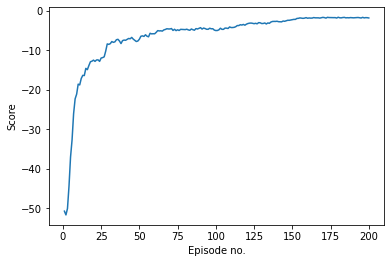

In [0]:
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
print(scores)
plt.plot([i+1 for i in range(0,200,1)], scores[:])
plt.xlabel('Episode no.')
plt.ylabel('Score')
plt.show()